# Plot example data for a single patient

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
%matplotlib inline

In [2]:
# Config
sqluser = 'postgres'
dbname = 'mimic'
schema_name = 'mimiciii'

In [3]:
# Connect to MIMIC
con = psycopg2.connect(dbname=dbname, user=sqluser)
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)
# cur.close()
# con.close()

In [4]:
# Select a single ICU stay
icustay_id = 293325

In [5]:
# Load admissions
query = """
SELECT ad.subject_id
  , ad.hadm_id
  , ad.admission_type
  , ad.diagnosis
  , ic.icustay_id
  , ic.first_careunit
  , ic.last_careunit
  , ic.intime as icu_intime
  , ad.hospital_expire_flag
  , pa.expire_flag
FROM admissions ad
INNER JOIN icustays ic
ON ad.subject_id = ic.subject_id
INNER JOIN patients pa
ON ad.subject_id = pa.subject_id
WHERE ic.icustay_id = """ + str(icustay_id) + """ 
ORDER BY ic.intime
"""

admissions = pd.read_sql_query(query,con)

In [6]:
# First few rows of admissions
admissions.head()

,subject_id,hadm_id,admission_type,diagnosis,icustay_id,first_careunit,last_careunit,icu_intime,hospital_expire_flag,expire_flag
0,62534,181366,EMERGENCY,NEUTROPENIC FEVER,293325,MICU,MICU,2120-10-29 10:32:50,1,1


In [7]:
# Load chartevents
query = """
SELECT ce.icustay_id
  , ce.charttime
  , ce.charttime - ie.intime AS icutime
  , di.label
  , ce.value
  , ce.valuenum
  , ce.valueuom
FROM chartevents ce
INNER join d_items di
ON ce.itemid = di.itemid
INNER join icustays ie
ON ce.icustay_id = ie.icustay_id
WHERE ce.icustay_id = """ + str(icustay_id) + """
AND error != 1
ORDER BY ce.charttime
"""

charts = pd.read_sql_query(query,con)

In [8]:
# First few rows of charts
charts.head()

,icustay_id,charttime,icutime,label,value,valuenum,valueuom
0,293325,2120-10-29 10:30:00,-1 days +23:57:10,Inspired O2 Fraction,70,70,
1,293325,2120-10-29 10:30:00,-1 days +23:57:10,O2 Flow,10,10,L/min
2,293325,2120-10-29 10:34:00,00:01:10,O2 saturation pulseoxymetry,88,88,%
3,293325,2120-10-29 10:34:00,00:01:10,Respiratory Rate,17,17,insp/min
4,293325,2120-10-29 10:34:00,00:01:10,Heart Rate,106,106,bpm


In [9]:
# Load outputevents
query = """
SELECT oe.icustay_id
  , oe.charttime
  , oe.charttime - ie.intime AS icutime
  , di.label
  , oe.value
  , oe.valueuom
FROM outputevents oe 
INNER JOIN icustays ie
  ON oe.icustay_id = ie.icustay_id
INNER JOIN d_items di
  ON oe.itemid = di.itemid
WHERE oe.icustay_id = """ + str(icustay_id) + """
ORDER BY oe.charttime
"""

outputs = pd.read_sql_query(query,con)

In [10]:
# First few rows of outputs
outputs.head()

,icustay_id,charttime,icutime,label,value,valueuom
0,293325,2120-10-29 10:45:00,00:12:10,Foley,50,mL
1,293325,2120-10-29 11:30:00,00:57:10,Foley,100,mL
2,293325,2120-10-29 12:00:00,01:27:10,Foley,35,mL
3,293325,2120-10-29 13:00:00,02:27:10,Foley,50,mL
4,293325,2120-10-29 14:00:00,03:27:10,Foley,40,mL


In [11]:
# Load inputevents
query = """
SELECT inp.icustay_id
  , inp.starttime
  , inp.endtime
  , inp.starttime - ie.intime AS icustarttime
  , inp.endtime - ie.intime AS icuendtime
  , di.label
  , inp.amount
  , inp.amountuom
  , inp.rate
  , inp.rateuom
FROM inputevents_mv inp 
INNER join icustays ie
  ON inp.icustay_id = ie.icustay_id
INNER join d_items di
  ON inp.itemid = di.itemid
WHERE inp.icustay_id = """ + str(icustay_id) + """
AND lower(inp.statusdescription) != 'rewritten'
ORDER BY inp.starttime
"""

inputs = pd.read_sql_query(query,con)

In [12]:
# First few rows of inputs
inputs.head()

,icustay_id,starttime,endtime,icustarttime,icuendtime,label,amount,amountuom,rate,rateuom
0,293325,2120-10-29 11:57:00,2120-10-29 11:58:00,01:24:10,0 days 01:25:10,NaCl 0.9%,500.000000,mL,NaN,
1,293325,2120-10-29 12:00:00,2120-10-30 12:54:00,01:27:10,1 days 02:21:10,NaCl 0.9%,250.000014,mL,10.040161,mL/hour
2,293325,2120-10-29 15:52:00,2120-10-29 15:53:00,05:19:10,0 days 05:20:10,Dextrose 5%,100.000000,mL,NaN,
3,293325,2120-10-29 15:52:00,2120-10-29 15:53:00,05:19:10,0 days 05:20:10,Piperacillin/Tazobactam (Zosyn),1.000000,dose,NaN,
4,293325,2120-10-29 16:15:00,2120-10-29 16:16:00,05:42:10,0 days 05:43:10,Dextrose 5%,100.000000,mL,NaN,


In [13]:
# Load labevents
query = """
SELECT le.subject_id
  , ie.icustay_id
  , le.charttime
  , le.charttime - ie.intime AS icutime
  , di.label
  , le.value
  , le.valuenum
  , le.valueuom
FROM labevents le
INNER join icustays ie
  ON le.subject_id = ie.subject_id
  AND le.charttime >= ie.intime
  AND le.charttime <= ie.outtime
INNER JOIN d_labitems di
  ON le.itemid = di.itemid
WHERE ie.icustay_id = """ + str(icustay_id) + """
ORDER BY le.charttime
"""

labs = pd.read_sql_query(query,con)

In [14]:
# First few rows of labs
labs.head()

,subject_id,icustay_id,charttime,icutime,label,value,valuenum,valueuom
0,62534,293325,2120-10-29 10:38:00,00:05:10,RBC,1,1.000,#/hpf
1,62534,293325,2120-10-29 10:38:00,00:05:10,WBC,1,1.000,#/hpf
2,62534,293325,2120-10-29 10:38:00,00:05:10,PROTEIN,30,30.000,mg/dL
3,62534,293325,2120-10-29 10:38:00,00:05:10,PH,6.5,6.500,units
4,62534,293325,2120-10-29 10:38:00,00:05:10,SPECIFIC GRAVITY,1.013,1.013,


In [15]:
# Snip data to specified number of days
maxdays = 5;
charts = charts.loc[charts.icutime.dt.days<=maxdays]
outputs = outputs.loc[outputs.icutime.dt.days<=maxdays]
inputs = inputs.loc[inputs.icustarttime.dt.days<=maxdays]
labs = labs.loc[labs.icutime.dt.days<=maxdays]

In [16]:
# Create column with minutes from ICU intime
charts['icutimehr'] = (charts['icutime'].dt.seconds/60/60)+(charts['icutime'].dt.days*24)
outputs['icutimehr'] = (outputs['icutime'].dt.seconds/60/60)+(outputs['icutime'].dt.days*24)
inputs['icustarttimehr'] = (inputs['icustarttime'].dt.seconds/60/60)+(inputs['icustarttime'].dt.days*24)
inputs['icuendtimehr'] = (inputs['icuendtime'].dt.seconds/60/60)+(inputs['icuendtime'].dt.days*24)
labs['icutimehr'] = (labs['icutime'].dt.seconds/60/60)+(labs['icutime'].dt.days*24)

In [17]:
# What are the most commonly measured variables in charts?
charts['label'].value_counts().head()

O2 saturation pulseoxymetry              62
Respiratory Rate                         62
Heart Rate                               61
Non Invasive Blood Pressure mean         54
Non Invasive Blood Pressure diastolic    53
Name: label, dtype: int64

In [18]:
# What are the most commonly measured variables in charts?
outputs['label'].value_counts().head()

Foley    29
Name: label, dtype: int64

In [19]:
# What are the most commonly measured variables in charts?
inputs['label'].value_counts().head()

Morphine Sulfate                   19
Dextrose 5%                        13
NaCl 0.9%                           7
PO Intake                           6
Piperacillin/Tazobactam (Zosyn)     4
Name: label, dtype: int64

In [20]:
# What are the most commonly measured variables in charts?
labs.mean()

subject_id     62534.000000
icustay_id    293325.000000
valuenum          55.119066
icutimehr         13.038909
dtype: float64

In [21]:
# Get average values
hr_mean = charts.valuenum[charts.label=='Heart Rate'].mean()
bp_mean = charts.icutimehr[charts.label=='Non Invasive Blood Pressure mean'].mean()
temp_mean = ((charts.valuenum[charts.label=='Temperature Fahrenheit']-32)/1.8).mean()

# Print averages
print("Mean HR is: {0:.2f}".format(hr_mean))
print("Mean BP is: {0:.2f}".format(bp_mean))
print("Mean temp, C is: {0:.2f}".format(temp_mean))


Mean HR is: 98.89
Mean BP is: 22.62
Mean temp, C is: 36.33


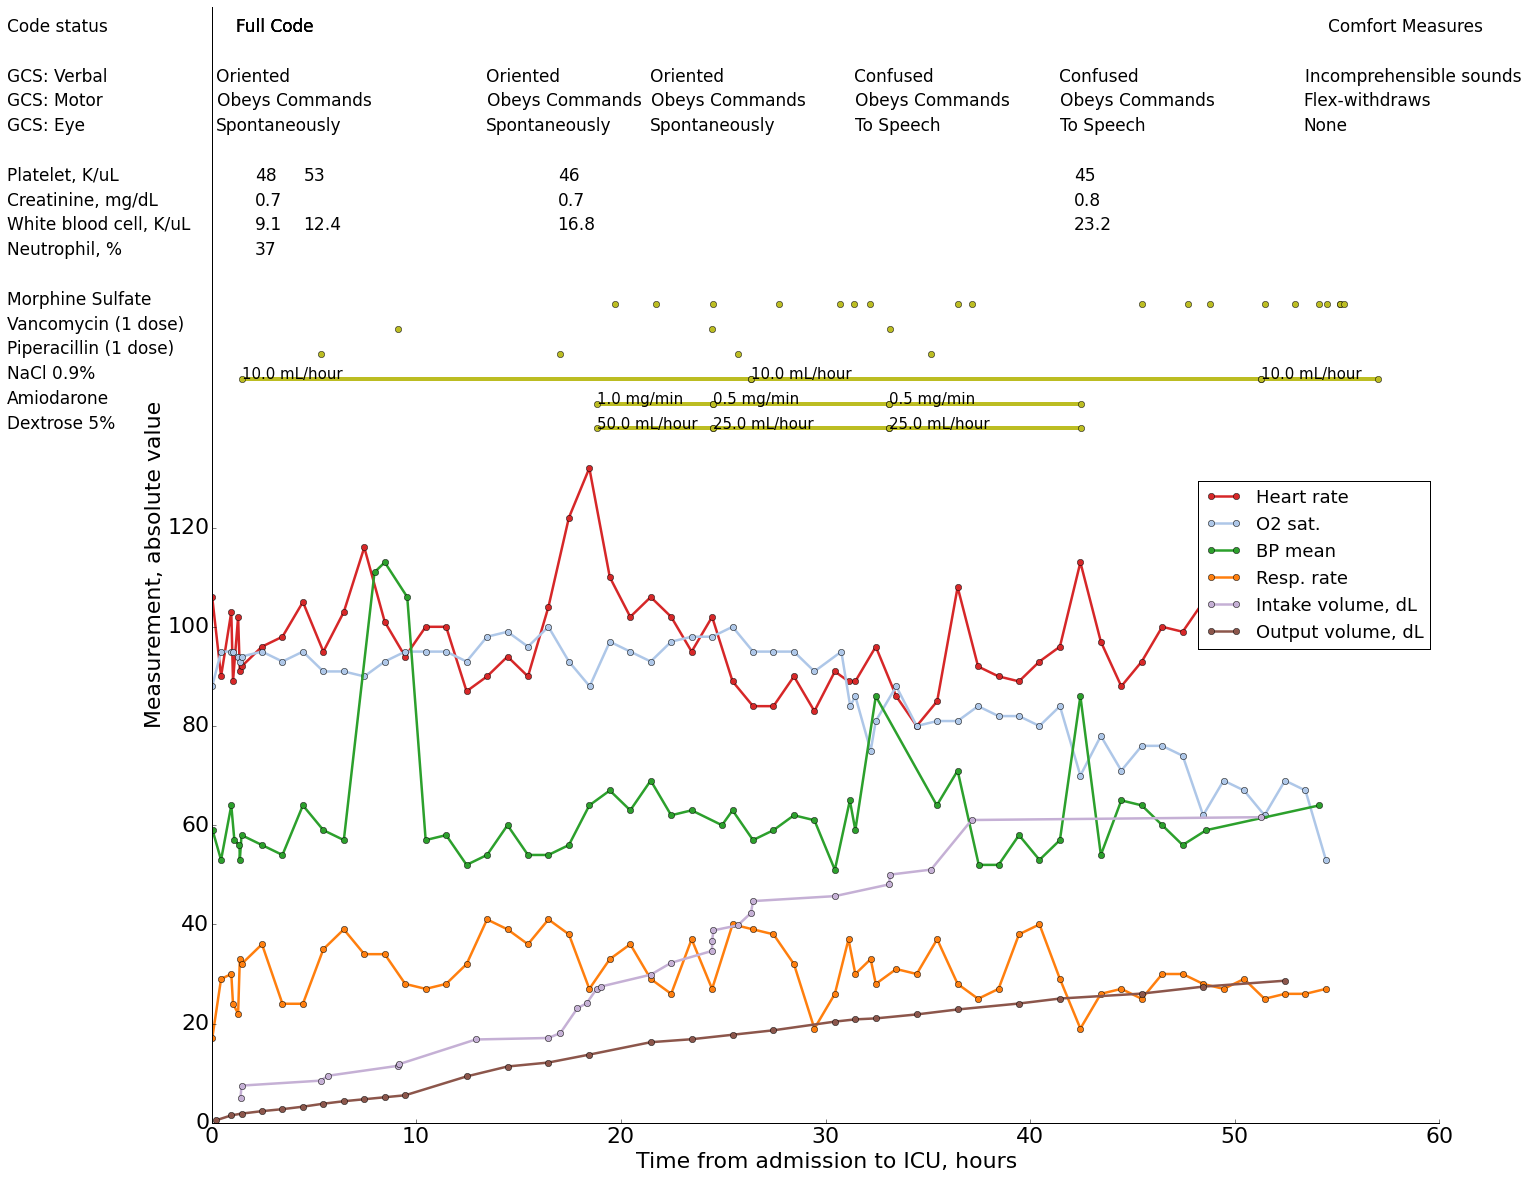

In [22]:
# Plot sample data over first 24 hours from admission to ICU
# Credit: Randal Olson for styling (http://www.randalolson.com/2014/06/28/)

# Prepare the size of the figure
fig = plt.figure(figsize=(22, 20))
plt.rcParams.update({'font.size': 22})

# "Tableau 20" colors as RGB.   
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]  
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)
    
# Remove the plot frame lines. 
ax = plt.subplot(111)    
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(True)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(True)    
  
# Ensure that the axis ticks only show up on the bottom and left of the plot.      
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left() 
ax.axis([0,60,0,225])

# Plot vital signs
plt.plot(charts.icutimehr[charts.label=='Heart Rate'], 
         charts.valuenum[charts.label=='Heart Rate'],
         color=tableau20[6], lw=2.5,
         marker='o', markersize=6, label='Heart rate')

plt.plot(charts.icutimehr[charts.label=='O2 saturation pulseoxymetry'], 
         charts.valuenum[charts.label=='O2 saturation pulseoxymetry'],
         color=tableau20[1], lw=2.5, 
         marker='o', markersize=6, label='O2 sat.')

plt.plot(charts.icutimehr[charts.label=='Non Invasive Blood Pressure mean'], 
         charts.valuenum[charts.label=='Non Invasive Blood Pressure mean'],
         color=tableau20[4], lw=2.5,
         marker='o', markersize=6, label='BP mean')

plt.plot(charts.icutimehr[charts.label=='Respiratory Rate'], 
         charts.valuenum[charts.label=='Respiratory Rate'],
         color=tableau20[2], lw=2.5,
         marker='o', markersize=6, label='Resp. rate')

# for i, txt in enumerate(charts.value[charts.label=='Temperature Fahrenheit'].values):
#         plt.annotate(txt,(charts.icutimehr[charts.label=='Temperature Fahrenheit'].
#                            values[i],140),fontsize=15)

# Plot input/output events
plt.plot(inputs.icustarttimehr[inputs.amountuom=='mL'], 
         inputs.amount[inputs.amountuom=='mL'].cumsum()/100, 
         color=tableau20[9], lw=2.5,
         marker='o', markersize=6, label='Intake volume, dL')

plt.plot(outputs.icutimehr, 
         outputs.value.cumsum()/100, 
         color=tableau20[10], lw=2.5,
         marker='o', markersize=6, label='Output volume, dL')

# Plot intravenous meds
plt.text(-10,150,'NaCl 0.9%',fontsize=17)
for i,row in inputs.loc[(inputs["label"] =='NaCl 0.9%') & (inputs["rate"] > 0)].iterrows():
    plt.plot([row['icustarttimehr'],row['icuendtimehr']],[150]*2,
             color=tableau20[16], lw=4,marker='o', markersize=6)
    plt.text(row['icustarttimehr'],150,
             str(round(row['rate'],1)) + ' ' + str(row['rateuom']),
             fontsize=15)

plt.text(-10,145,'Amiodarone',fontsize=17)
for i,row in inputs.loc[(inputs["label"] =='Amiodarone 600/500') & (inputs["rate"] > 0)].iterrows():
    plt.plot([row['icustarttimehr'],row['icuendtimehr']],[145]*2,
             color=tableau20[16], lw=4,marker='o', markersize=6)
    plt.text(row['icustarttimehr'],145,
             str(round(row['rate'],1)) + ' ' + str(row['rateuom']),
             fontsize=15)    

plt.text(-10,140,'Dextrose 5%',fontsize=17)
for i,row in inputs.loc[(inputs["label"] =='Dextrose 5%') 
                        & (inputs["rate"] > 0) & (inputs["rate"] < 500)].iterrows():
    plt.plot([row['icustarttimehr'],row['icuendtimehr']],[140]*2,
             color=tableau20[16], lw=4,marker='o', markersize=6)
    plt.text(row['icustarttimehr'],140,
             str(round(row['rate'],1)) + ' ' + str(row['rateuom']),
             fontsize=15)    

plt.text(-10,165,'Morphine Sulfate',fontsize=17)
plt.plot(inputs.icustarttimehr[inputs.label=='Morphine Sulfate'],
          [165]*len(inputs[inputs.label=='Morphine Sulfate']),
          color=tableau20[16], lw=0, marker='o', markersize=6)   
    
plt.text(-10,160,'Vancomycin (1 dose)',fontsize=17)
plt.plot(inputs.icustarttimehr[inputs.label=='Vancomycin'],
          [160]*len(inputs[inputs.label=='Vancomycin']),
          color=tableau20[16], lw=0, marker='o', markersize=6)
    
plt.text(-10,155,'Piperacillin (1 dose)',fontsize=17)
plt.plot(inputs.icustarttimehr[inputs.label=='Piperacillin/Tazobactam (Zosyn)'],
         [155]*len(inputs[inputs.label=='Piperacillin/Tazobactam (Zosyn)']),
         color=tableau20[16], lw=0, marker='o', markersize=6)


# Plot labs
plt.text(-10,175,'Neutrophil, %',fontsize=17)
for i, txt in enumerate(labs.value[labs.label=='NEUTROPHILS'].values):
        plt.annotate(txt, (labs.icutimehr[labs.label=='NEUTROPHILS'].
                           values[i],175),fontsize=17) 

plt.text(-10,180,'White blood cell, K/uL',fontsize=17)
for i, txt in enumerate(labs.value[labs.label=='WHITE BLOOD CELLS'].values):
        plt.annotate(txt, (labs.icutimehr[labs.label=='WHITE BLOOD CELLS'].
                           values[i],180),fontsize=17)

plt.text(-10,185,'Creatinine, mg/dL',fontsize=17)        
for i, txt in enumerate(labs.value[labs.label=='CREATININE'].values):
        plt.annotate(txt, (labs.icutimehr[labs.label=='CREATININE'].
                           values[i],185),fontsize=17)

plt.text(-10,190,'Platelet, K/uL',fontsize=17)
for i, txt in enumerate(labs.value[labs.label=='PLATELET COUNT'].values):
        plt.annotate(txt, (labs.icutimehr[labs.label=='PLATELET COUNT'].
                           values[i],190),fontsize=17)

# Plot Glasgow Coma Scale
plt.text(-10,200,'GCS: Eye',fontsize=17)
for i, txt in enumerate(charts.value[charts.label=='GCS - Eye Opening'].values):
    if np.mod(i,2)==0 and i < 65:
        plt.annotate(txt, (charts.icutimehr[charts.label=='GCS - Eye Opening'].
                           values[i],200),fontsize=17)

plt.text(-10,205,'GCS: Motor',fontsize=17)
for i, txt in enumerate(charts.value[charts.label=='GCS - Motor Response'].values):
    if np.mod(i,2)==0 and i < 65:
        plt.annotate(txt, (charts.icutimehr[charts.label=='GCS - Motor Response'].
                           values[i],205),fontsize=17)

plt.text(-10,210,'GCS: Verbal',fontsize=17)  
for i, txt in enumerate(charts.value[charts.label=='GCS - Verbal Response'].values):
    if np.mod(i,2)==0 and i < 65:
        plt.annotate(txt, (charts.icutimehr[charts.label=='GCS - Verbal Response'].
                           values[i],210),fontsize=17)

# Plot code status
plt.text(-10,220,'Code status',fontsize=17) 
for i, txt in enumerate(charts.value[charts.label=='Code Status'].values):
        plt.annotate(txt, (charts.icutimehr[charts.label=='Code Status'].
                           values[i],220),fontsize=17)
        
plt.legend(loc=5,fontsize=18)
plt.xlabel('Time from admission to ICU, hours', fontsize=22)
plt.ylabel('Measurement, absolute value', fontsize=22)
plt.yticks(np.arange(0, 140, 20))

# Save the figure
fig.savefig('examplepatient.svg', bbox_inches='tight')